# Конкурентное равновесие в сети из параллельных каналов

**Постановка задачи** <br>
Рассмотрим сеть, представленную ориентированным графом G, состоящим из двух узлов (исток, сток) и n непересекающихся дуг (маршрутов). Будем называть такую сеть сетью из параллельных каналов. Совокупный поток между истоком и стоком будем обозначать через $F$ , а распределение $F$ по дугам будем обозначать через 
$$f_i \geqslant0, i=\overline{1,n}$$ 
$$\sum_{i=1}^n{f_i}=F$$

Время перемещения потока из истока в сток по дуге будем описывать гладкой неубывающей функцией на множестве неотрицательных вещественных чисел: 
$$t_i \in C^1(R^+) s.t. t_i(x)-t_i(y) \geqslant 0$$ 
$$x-y\geqslant0; x,y \in R^+$$ 
где $R^+$ $-$ множество неотрицательных вещественных чисел.<br>
Данная функция называется задержкой или стоимостью при перемещении по дуге.<br>
<br>
Также введём $f = (f_1,...,f_n), t(f) = (t_1(f_1),...,t_n(f_n))$ и **f** = $f^T$.<br>
Необходимо найти $f^∗ = (f_1^∗,...,f_n^∗)$, что время передвижения из истока в сток одинаково для каждой используемой дуги и меньше времени свободного движения по любой неиспользуемой дуге

### Оптимизационная задача
$$min \sum_{i=1}^{n}{\int_0^{f_i}t_i(u)du}$$
$$\sum_{i=1}^n{f_i}=F$$
$$f_i \geqslant0, i=\overline{1,n}$$  

<center>**Шаг 0**</center>
<center>Инициализация<center>

In [77]:
import numpy as np
import random

In [240]:
n = 2
F = 500
f_i = np.ones(n)*F/n

a = [random.uniform(1, n) for _ in range(n)]
c = [random.uniform(1, n) for _ in range(n)]

f_a_c_mat = np.array([(f, a_j, c_j) for f, a_j, c_j in zip(f_i, a, c)])

int_t_i = lambda f_i, a, c : f_i**4/(a)**3 + c * f_i
z = lambda f_i, a=a, c=c : sum([t_i(f_j, a_i, c_i) for f_j, a_i, c_i in zip(f_i, a, c)])
t_i = lambda f_i, a, c : (f_i/a)**3 + c
dt_i = lambda f_i, a, c: 3*(f_i/a)**2

a_i = lambda f_i, a, c: t_i(f_i, a, c) - dt_i(f_i, a, c) * f_i
b_i = lambda f_i, a, c: dt_i(f_i, a, c)

**Утилитарные функции**

<center>**Шаг 1**</center>
<center>сортируем $f_i$ т.ч. $a_1(f_i^k) \leqslant \dots \leqslant a_n(f_n^k)$</center>
<center>**Шаг 2 (в начале)**</center>
<center>$m^k:= $ количество ненулевых переменных в $f_i$</center>
<center>**Шаг 2 (в цикле)**</center>
<center>$m^k$ определяется из неравенства:</center>
<center>$a_{m_k}\leqslant \omega^* < a_{m_k + 1}$; where $\omega^* = \frac{F + \sum_{i=1}^{m_k}{a_i(f_i^k)}}{\sum_{s=1}^{m_k}{\frac{1}{b_i(f_i^k)}}}$<center>

In [238]:
def find_m_k(f_i, mk):
    """
        gets f_i -- matrix of f_i, a, c
        mk is previous index
        
        returns m_k based on *Шаг 2 (в цикле)*
    """
    omega_k = (F + np.sum(
                a_i(f_i[:mk, 0], f_i[:mk, 1], f_i[:mk, 2]))
              ) / (np.sum(1/b_i(f_i[:mk, 0], f_i[:mk, 1], f_i[:mk, 2])))
    for m_k in range(n-1):
        left = a_i(f_i[m_k, 0], f_i[m_k, 1], f_i[m_k, 2])
        right = a_i(f_i[m_k + 1, 0], f_i[m_k + 1, 1], f_i[m_k + 1, 2])
        if(omega_k > left and omega_k < right):
            print(m_k)
            return m_k
    return n

<center>**Шаг 3 (next_f_i; ниже)**</center>
<center>
$f_i^{k+1}= 
\begin{cases}
    \frac{1}{b_i(f_i^k)} 
    \cdot 
    \frac{F+\sum_{s=1}^{m_k}{\frac{a_s(f_s^k)}{b_s(f_s^k)}}}{\sum_{s=1}^{m_k}{\frac{1}{b_s(f_s^k)}}} - 
    \frac{a_i(f_i^k)}{b_i(f_i^k)},           & \text{if } i\leq m^k\\
    0,                                       & \text{if }  i > m^k
\end{cases}$
</center>

In [234]:
def next_f_i(f_i, m_k):
    """
    gets f_i -- matrix of f_i, a, c
         m_k -- index to stop summing
         
    returns next approx of f_i
    """
    f_next = f_i.copy()
    for i, f_i_k in enumerate(f_i[:, 0]):
        if i <= m_k:
            fst = 1/b_i(f_i_k, f_i[i, 1], f_i[i, 2])
            scnd = (F+np.sum(
                    a_i(f_i[:m_k, 0], f_i[:m_k, 1], f_i[:m_k, 2])/b_i(f_i[:m_k, 0], f_i[:m_k, 1], f_i[:m_k, 2]))
                   ) / (np.sum((1)/(b_i(f_i[:m_k, 0], f_i[:m_k, 1], f_i[:m_k, 2]))))
            trd = a_i(f_i_k, f_i[i, 1], f_i[i, 2])/b_i(f_i_k, f_i[i, 1], f_i[i, 2])
            f_next[i, 0] = fst*scnd - trd
        else:
            f_next[i, 0] = 0
    return f_next

### Минимизация

In [252]:
from scipy.spatial.distance import cosine, sqeuclidean
from numpy.linalg import norm
f_a_c_mat = np.array([(f, a_j, c_j) for f, a_j, c_j in zip(f_i, a, c)])
precision = 1
eps = 1e-3
# Шаг 2 в начале
m_k = np.count_nonzero(f_i)
while precision > eps:
#    Шаг 1
    f_a_c_mat = np.array(sorted(f_a_c_mat, key=lambda f: a_i(f[0], f[1], f[2])))
#    Шаг 2 в цикле
    m_k = find_m_k(f_a_c_mat, m_k)
#    Шаг 3
    next_f = next_f_i(f_a_c_mat, m_k)
        
    precision = sqeuclidean(dt_i(next_f[:, 0], next_f[:, 1], next_f[:, 2]),
                               dt_i(f_a_c_mat[:, 0], f_a_c_mat[:, 1], f_a_c_mat[:, 2]))

    f_a_c_mat = next_f

    print('Cледующее приближение:')
    print(next_f[:, 0])
    print('Точность = {prec}'.format(prec=precision))
    print()

Cледующее приближение:
[ 249.82119605  250.17880395]
Точность = 16018.82009958263

Cледующее приближение:
[ 249.74567816  250.25432184]
Точность = 2857.4199528240715

Cледующее приближение:
[ 250.28621678  249.71378322]
Точность = 509.703012523313

Cледующее приближение:
[ 250.29968759  249.70031241]
Точность = 90.92022125897137

Cледующее приближение:
[ 250.30537697  249.69462303]
Точность = 16.2182463510748

Cледующее приближение:
[ 250.30777988  249.69222012]
Точность = 2.892992885497044

Cледующее приближение:
[ 250.30879475  249.69120525]
Точность = 0.5160489123586047

Cледующее приближение:
[ 250.30922338  249.69077662]
Точность = 0.09205224420440015

Cледующее приближение:
[ 250.30940441  249.69059559]
Точность = 0.016420179507071163

Cледующее приближение:
[ 250.30948087  249.69051913]
Точность = 0.0029290138276450925

Cледующее приближение:
[ 250.30951316  249.69048684]
Точность = 0.0005224743122672297



### Сравнение со стандартным методом минимизации

In [249]:
from scipy.optimize import minimize
cond = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) - F},
        {'type' : 'ineq', 'fun' : lambda x: x})

In [250]:
minimize(fun=z, x0=f_i, constraints=cond, tol = 1e-3)

     fun: 6023427.0409735404
     jac: array([ 36140.625,  36140.5  ,      0.   ])
 message: 'Optimization terminated successfully.'
    nfev: 11
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 249.53564946,  250.46435054])

### График будет работать, только при n = 2

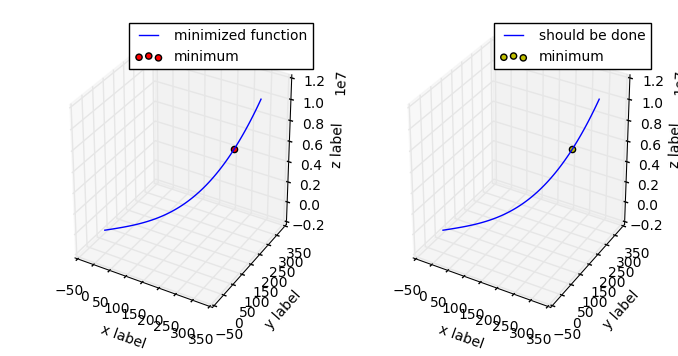

In [257]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

x_k = f_a_c_mat[:, 0]
x_actual = minimize(fun=z, x0=f_i, constraints=cond, tol = 1e-3).x

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=plt.figaspect(0.5))
plt.hold(True)
plt.axis('off')

x = np.linspace(0, 300, 100)
y = np.linspace(0, 300, 100)
zax = np.array([z(xi, f_a_c_mat[:, 1], f_a_c_mat[:, 2]) for xi in zip(x, y)])

ax = fig.add_subplot(1, 2, 1, projection='3d')


ax.plot(x, y, zax, label = 'minimized function')
ax.scatter(x_k[0], x_k[1], z(x_k, f_a_c_mat[:, 1], f_a_c_mat[:, 2]), c='r', label = 'minimum')

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.set_zlabel('z label')

ax.legend()


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot(x, y, zax, label = 'should be done')
ax.scatter(x_actual[0], x_actual[1], z(x_actual), c='y', label = 'minimum')

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.set_zlabel('z label')

ax.legend()

plt.show()